In [31]:
# Linear versus quadratic model estimation
# hollander et al., 2021
# test for decoding accuracy
# increase linearly or show a clear peak at a specific cortical depth
# perform bayesian model comparison

# fit two hierarhical linear models using pymc
# NUTS sampler

# dependent variable (decoding accuracy) was first modeled as a linear function of cortical depth
# y_n = theta_n,0 + theta_n,1 * d_n

# and then also as a quadratic function of cortical depth
# y_n = theta_n,0 + theta_n,1 * d_n * theta_n,2 * d^2

# where y_n were all observationf for subjects n
# d is a corresponding vector of cortical depths
# theta_n is the parameter vector for subject n that was estimated

# the subject-wise parameters were modeled as coming from Gaussian group distirbution mean mu and standard deviation sigma
# theta ~ N(mu, sigma)
# mu ~ N(0, 1)
# sigma ~ HalfCauchy(5) -> 5 subjects?

# (1) use the state-of-the-art Watanabe-Akaike informatoin criterion to do Bayesian model copmarison between the linear and quadratic models
# (2) estimate the posterior of the peak of the quadratic function using the formula 

In [32]:
from pathlib import Path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pymc as pm
import arviz as az
from src.config import SUBJECTS, SESSION, N_LAYER

def get_profile(subj, sess, day):
    path = Path(DIR_DATA) / subj / f"{sess}{SESSION[subj][sess][day]}"
    file = path / "bandpass_none" / "accuracy.csv"
    data = np.genfromtxt(file, delimiter=',')
    return data

SESS = "VASO"
DIR_DATA = "/data/pt_01880/Experiment1_ODC/paper/decoding"

x = []
y = []
group = []
for i, subj in enumerate(SUBJECTS):
    for day in [0, 1]:
        x.extend(np.reshape(np.repeat(np.arange(N_LAYER),10), (11, 10)).flatten())
        y.extend(get_profile(subj, SESS, day).flatten() * 100)
        group.extend(i * np.ones_like(get_profile(subj, SESS, day).flatten(), dtype=np.int64))

In [33]:
#n_group = int(np.max(group)+1)
#with pm.Model():
#    # hyperpriors
#    # sigma: model the uncertainty of our parent distributions
#    mu_theta0 = pm.Normal("mu_theta0", 0, 1)
#    mu_theta1 = pm.Normal("mu_theta1", 0, 1)
#    sigma_theta0 = pm.HalfCauchy("sigma_theta0", n_group)
#    sigma_theta1 = pm.HalfCauchy("sigma_theta1", 5)

#    theta0 = pm.Gamma("theta0", mu_theta0, sigma_theta0, shape=n_group)
#    theta1 = pm.Gamma("theta1", mu_theta1, sigma_theta1, shape=n_group)
#    sigma_margin = pm.Exponential("sigma_margin", 0.1)

#    y_est = theta0[group] + theta1[group] * x
#    y_like = pm.Normal(
#        "y_like",
#        mu=y_est,
#        sigma=sigma_margin,
#        observed=y,
#    )

#    trace = pm.sample(
#        draws=10000,
#        tune=500,
#        chains=5,
#        progressbar=True,
#        target_accept=0.95,
#        return_inferencedata=True,
#    )

In [41]:
with pm.Model():
    ## define Normal priors to give Ridge regression
    b0 = pm.Normal("Intercept", mu=0, sigma=100)
    b1 = pm.Normal("slope", mu=0, sigma=100)

    ## define Linear model
    #yest = b0 + b1 * x
    yest = b0*pm.math.cos(x) + b1

    ## define Normal likelihood with HalfCauchy noise (fat tails, equiv to HalfT 1DoF)
    y_sigma = pm.HalfCauchy("y_sigma", beta=10)
    likelihood = pm.Normal("likelihood", mu=yest, sigma=y_sigma, observed=y)

    idata = pm.sample(2000, return_inferencedata=True, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, slope, y_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


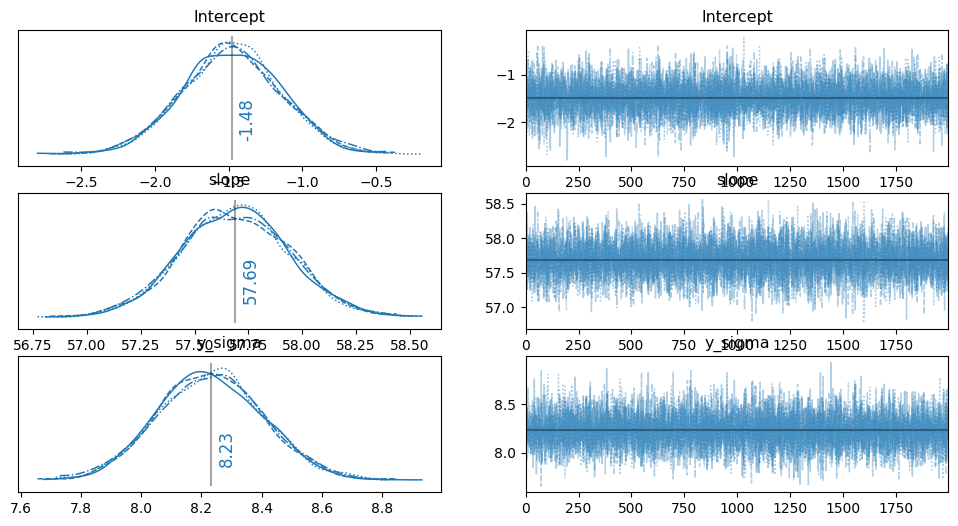

In [42]:
def plot_annotated_trace(traces):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """

    summary = az.summary(traces, stat_funcs={"mean": np.mean}, extend=False)
    ax = az.plot_trace(
        traces,
        lines=tuple([(k, {}, v["mean"]) for k, v in summary.iterrows()]),
    )

    for i, mn in enumerate(summary["mean"].values):
        ax[i, 0].annotate(
            f"{mn:.2f}",
            xy=(mn, 0),
            xycoords="data",
            xytext=(5, 10),
            textcoords="offset points",
            rotation=90,
            va="bottom",
            fontsize="large",
            color="C0",
        )

#plt.rcParams["figure.constrained_layout.use"] = True
plot_annotated_trace(idata)

In [43]:
az.waic(idata, scale="deviance")

Computed from 8000 posterior samples and 1100 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  7761.64    45.48
p_waic            2.96        -

In [37]:
y

[51.515151515151516,
 46.96969696969697,
 63.63636363636363,
 56.060606060606055,
 48.484848484848484,
 57.57575757575758,
 54.54545454545454,
 48.484848484848484,
 53.03030303030303,
 43.93939393939394,
 62.121212121212125,
 69.6969696969697,
 72.72727272727273,
 48.484848484848484,
 54.54545454545454,
 50.0,
 80.3030303030303,
 53.03030303030303,
 62.121212121212125,
 56.060606060606055,
 66.66666666666666,
 68.18181818181817,
 65.15151515151516,
 59.09090909090909,
 56.060606060606055,
 63.63636363636363,
 57.57575757575758,
 48.484848484848484,
 59.09090909090909,
 72.72727272727273,
 74.24242424242425,
 66.66666666666666,
 65.15151515151516,
 78.78787878787878,
 63.63636363636363,
 63.63636363636363,
 53.03030303030303,
 59.09090909090909,
 69.6969696969697,
 56.060606060606055,
 60.60606060606061,
 69.6969696969697,
 65.15151515151516,
 63.63636363636363,
 69.6969696969697,
 53.03030303030303,
 51.515151515151516,
 57.57575757575758,
 74.24242424242425,
 60.60606060606061,
 53.03